# Data Collection

Collecting student data for CA116

Import libraries:

In [1]:
import os
import csv
import json
import datetime
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib config:

In [2]:
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 22 }
plt.rc('font', **font)

### Course

In [3]:
_course = 'ca116'

### Years

In [4]:
_years = [
    (2016, 2017),
    (2017, 2018),
    (2018, 2019),
]

### Grades

Results on the laboratory computer-based examinations:

In [5]:
df_grades = pd.read_json('../../data/raw/grades.json')

In [6]:
df_grades.head(2)

,academic_year_0,academic_year_1,exam_week,grade,module,user
0,2015,2016,12,10,ca116,corrigg2
1,2015,2016,12,10,ca116,hanleya3


In [7]:
'{:,}'.format(len(df_grades))

'1,284'

In [8]:
staff = [ 'sblott' ]

def get_grades(course, academic_year):
    return df_grades[(df_grades['academic_year_0'] == academic_year[0]) & 
                     (df_grades['academic_year_1'] == academic_year[1]) & 
                     (df_grades['module'] == course) & 
                     (~df_grades['user'].isin(staff))] # user not in staff

In [9]:
grades_students = get_grades(_course, _years[0]) # Academic Year: 2016, 2017

In [10]:
grades_students[grades_students['user'] == 'agnewm4']

,academic_year_0,academic_year_1,exam_week,grade,module,user
260,2016,2017,12,54,ca116,agnewm4
371,2016,2017,4,100,ca116,agnewm4
484,2016,2017,8,25,ca116,agnewm4


In [11]:
student_names = grades_students.user.unique()

In [12]:
len(student_names)

125

### Students per academic year

Dictionary of students every academic year:

In [13]:
students = {}

for _year in _years:
    
    # Students
    students[_year] = get_grades(_course, _year).user.unique()
    
    print('Course: {}, Year: {}, # Students: {}'.format(_course.upper(), _year, len(students[_year])))

Course: CA116, Year: (2016, 2017), # Students: 125
Course: CA116, Year: (2017, 2018), # Students: 156
Course: CA116, Year: (2018, 2019), # Students: 129


### Demographics

Dictionary of usernames and domiciles every academic year:

In [14]:
path = '../../data/demographics'

demographic_filenames = {
    (2016, 2017): [ os.path.join(path, "2017_bio_I.csv"), os.path.join(path, "2017_bio_II.csv") ],
    (2017, 2018): [ os.path.join(path, "2018_bio.csv") ],
    (2018, 2019): [ os.path.join(path, "2019_bio.csv") ],
}

cao_filenames = {
    (2016, 2017): [ os.path.join(path, "2017_leaving_cert_I.csv"), os.path.join(path, "2017_leaving_cert_II.csv"),
                    os.path.join(path, "2017_leaving_cert_III.csv"), os.path.join(path, "2017_leaving_cert_IV.csv"),
                    os.path.join(path, "2017_leaving_cert_V.csv"), os.path.join(path, "2017_leaving_cert_VI.csv"),
                  ],
    (2017, 2018): [ os.path.join(path, "2018_leaving_cert_I.csv"), os.path.join(path, "2018_leaving_cert_II.csv") ],
    (2018, 2019): [ os.path.join(path, "2019_leaving_cert.csv") ],
}

In [15]:
def get_demographic_data(years):
    
    # Students
    student_names = students[years]
    
    usernames = {}
    domiciles = {}
        
    for filename in demographic_filenames[years]:
        
        print('Reading {}'.format(filename))

        with open(filename, encoding='utf-8-sig') as f:

            for row in csv.DictReader(f):

                username = row["Username"].strip()
                domicile = row["Domicile"].strip()
                student_number = row['Student Number'].strip()
                username = row["Username"].strip()
                
                # Add username
                if username in student_names and student_number not in usernames: 
                    usernames[student_number] = username 

                # Add domicile
                if username in student_names and username not in domiciles:
                    domiciles[username] = domicile
                    
    # Students not present in the files
    not_present = [ student_name for student_name in student_names if student_name not in domiciles ]
                    
    return usernames, domiciles, not_present

In [16]:
usernames = {}
domiciles = {}
not_present = {}

2016 / 2017 academic year:

In [17]:
_year = (2016, 2017)
usernames[_year], domiciles[_year], not_present[_year] = get_demographic_data(_year)

Reading ../../data/demographics/2017_bio_I.csv
Reading ../../data/demographics/2017_bio_II.csv


2017 / 2018 academic year:

In [18]:
_year = (2017, 2018)
usernames[_year], domiciles[_year], not_present[_year] = get_demographic_data(_year)

Reading ../../data/demographics/2018_bio.csv


2018 / 2019 academic year:

In [19]:
_year = (2018, 2019)
usernames[_year], domiciles[_year], not_present[_year] = get_demographic_data(_year)

Reading ../../data/demographics/2019_bio.csv


In [20]:
for _year in _years:
    print('{} # usernames: {}, # domiciles: {}, # students not present: {}'.format(
        _year, len(usernames[_year]), len(domiciles[_year]), len(not_present[_year])))

(2016, 2017) # usernames: 115, # domiciles: 115, # students not present: 10
(2017, 2018) # usernames: 156, # domiciles: 156, # students not present: 0
(2018, 2019) # usernames: 129, # domiciles: 129, # students not present: 0


### CAO Points and Leaving Cert exams

Calculate score for Leaving Cert Maths based on the grades 

In [21]:
# http://www.cao.ie/index.php?page=points_calc
# http://www2.cao.ie/points/l8.php#dc8
# Different marking systems for:
# 1993-2016 Exams
# 2017-onwards Exams
def get_lc_exam_points(subject, level, grade):
    if subject == "MTH":
        return get_lc_math_points(level, grade)
    else:
        return get_lc_other_subject_points(level, grade)
    # LCV exam has a different marking system

In [22]:
def get_lc_math_points(level, grade):
    # Math Cert Level
    # Leaving Cert Level
    # Leaving Cert Grade
    if level == "H": # Higher
        if grade == "A1" or grade == "A" or grade == "H1":
            return 125
        elif grade == "A2" or grade == "B1" or grade == "B" or grade == "H2":
            return 113
        elif grade == "B2" or grade == "B3" or grade == "H3":
            return 102
        elif grade == "C1" or grade == "C2" or grade == "C" or grade == "H4":
            return 91
        elif grade == "C3" or grade == "D1" or grade == "D" or grade == "H5":
            return 81
        elif grade == "D2" or grade == "D3" or grade == "H6":
            return 71
        elif grade == "H7":
            return 37
        elif grade == "E":
            return 33
        elif grade == "F" or grade == "H8":
            return 0
    elif level == "O":
        if grade == "A1" or grade == "A" or grade == "O1":
            return 56
        elif grade == "A2" or grade == "B1" or grade == "B" or grade == "O2":
            return 46
        elif grade == "B2" or grade == "B3" or grade == "O3":
            return 37
        elif grade == "C1" or grade == "C2" or grade == "C" or grade == "O4":
            return 28
        elif grade == "C3" or grade == "D1" or grade == "D" or grade == "O5":
            return 20
        elif grade == "D2" or grade == "D3" or grade == "O6":
            return 12
        elif grade == "E" or grade == "F" or grade == "O7" or grade == "O8":
            return 0
    return None


def get_lc_other_subject_points(level, grade):
    # Subject Leaving Cert Points (Not Math)
    # Leaving Cert Level
    # Leaving Cert Grade
    if level == "H": # Higher
        if grade == "A1" or grade == "A" or grade == "H1":
            return 100
        elif grade == "A2" or grade == "B1" or grade == "B" or grade == "H2":
            return 88
        elif grade == "B2" or grade == "B3" or grade == "H3":
            return 77
        elif grade == "C1" or grade == "C2" or grade == "C" or grade == "H4":
            return 66
        elif grade == "C3" or grade == "D1" or grade == "D" or grade == "H5":
            return 56
        elif grade == "D2" or grade == "D3" or grade == "H6":
            return 46
        elif grade == "H7":
            return 37
        elif grade == "E":
            return 33
        elif grade == "F" or grade == "H8":
            return 0
    elif level == "O":
        if grade == "A1" or grade == "A" or grade == "O1":
            return 56
        elif grade == "A2" or grade == "B1" or grade == "B" or grade == "O2":
            return 46
        elif grade == "B2" or grade == "B3" or grade == "O3":
            return 37
        elif grade == "C1" or grade == "C2" or grade == "C" or grade == "O4":
            return 28
        elif grade == "C3" or grade == "D1" or grade == "D" or grade == "O5":
            return 20
        elif grade == "D2" or grade == "D3" or grade == "O6":
            return 12
        elif grade == "E" or grade == "F" or grade == "O7" or grade == "O8":
            return 0
    return None


Dictionary of points every academic year:

In [23]:
def get_cao_data(years, usernames):
    
    # Students
    student_names = students[years]   
        
    # CAO
    cao_points = {}
    math_grades = {}
        
    for filename in cao_filenames[years]:

        print('Reading {}'.format(filename))
        
        with open(filename, encoding='utf-8-sig') as f:

            for row in csv.DictReader(f):

                if "Username" in row:
                    username = row["Username"].strip()
                else:
                    student_number = row["Student Number"].strip()
                    
                    if student_number not in usernames:
                        continue
                    
                    username = usernames[student_number]
                
                points = row["CAO Points"].strip()

                if username in student_names and username not in cao_points:

                    cao_points[username] = points
                    
                if username in student_names and "Subject" in row and row["Subject"].strip() == 'MTH' \
                and username not in math_grades:
                    
                    grade = row["Grade"].strip()
                    symbol = row["Symbol"].strip()
                    math_grades[username] = get_lc_exam_points('MTH', grade, symbol)     
                    
    not_present_cao = [ student_name for student_name in student_names if student_name not in cao_points ]
                    
    return cao_points, math_grades, not_present_cao

In [24]:
cao_points = {}
math_grades = {}
not_present_cao = {}

In [25]:
_year = (2016, 2017)
cao_points[_year], math_grades[_year], not_present_cao[_year] = get_cao_data(_year, usernames[_year])

Reading ../../data/demographics/2017_leaving_cert_I.csv
Reading ../../data/demographics/2017_leaving_cert_II.csv
Reading ../../data/demographics/2017_leaving_cert_III.csv
Reading ../../data/demographics/2017_leaving_cert_IV.csv
Reading ../../data/demographics/2017_leaving_cert_V.csv
Reading ../../data/demographics/2017_leaving_cert_VI.csv


In [26]:
_year = (2017, 2018)
cao_points[_year], math_grades[_year], not_present_cao[_year] = get_cao_data(_year, usernames[_year])

Reading ../../data/demographics/2018_leaving_cert_I.csv
Reading ../../data/demographics/2018_leaving_cert_II.csv


In [27]:
_year = (2018, 2019)
cao_points[_year], math_grades[_year], not_present_cao[_year] = get_cao_data(_year, usernames[_year])

Reading ../../data/demographics/2019_leaving_cert.csv


In [28]:
for _year in _years:
    print('{} # usernames: {}, # cao_points: {}, # math grades: {}, # students not present in CAO: {}'.format(
        _year, len(usernames[_year]), len(cao_points[_year]), len(math_grades[_year]), len(not_present_cao[_year])))

(2016, 2017) # usernames: 115, # cao_points: 122, # math grades: 115, # students not present in CAO: 3
(2017, 2018) # usernames: 156, # cao_points: 151, # math grades: 151, # students not present in CAO: 5
(2018, 2019) # usernames: 129, # cao_points: 114, # math grades: 114, # students not present in CAO: 15


### Gather data

In [29]:
data = []

for _year in _years:
    
    for _student_name in students[_year]:
        
        domicile = domiciles[_year][_student_name] if _student_name in domiciles[_year] else float('nan')
        cao = cao_points[_year][_student_name] if _student_name in cao_points[_year] else float('nan')
        math = math_grades[_year][_student_name] if _student_name in math_grades[_year] else float('nan')
        
        # print('Year: {}, Student: {}, Domicile: {}, CAO: {}, Math: {}'.format(
        #     _year, _student_name, domicile, cao, math))
        
        data.append({
            'academic_year_0': _year[0],
            'academic_year_1': _year[1],
            'student': _student_name,
            'domicile': domicile,
            'cao_points': cao,
            'math_leaving_cert': math,
        })

In [30]:
with open(os.path.join(path, 'summary.json'), 'w') as outfile:  
    json.dump(data, outfile)

In [31]:
ls '../../data/demographics/summary.json'

../../data/demographics/summary.json


### Exploring the new dataset

In [32]:
df = pd.DataFrame(data)

In [33]:
df.head()

,academic_year_0,academic_year_1,cao_points,domicile,math_leaving_cert,student
0,2016,2017,450,75,81.0,afanaa2
1,2016,2017,465,67,91.0,agnewm4
2,2016,2017,425,11,46.0,ahernes3
3,2016,2017,NaN,NaN,NaN,alamila2
4,2016,2017,976,60,37.0,alsafaf2


In [34]:
df.dtypes

academic_year_0        int64
academic_year_1        int64
cao_points            object
domicile              object
math_leaving_cert    float64
student               object
dtype: object

In [35]:
df['cao_points'] = pd.to_numeric(df['cao_points'], errors='coerce')

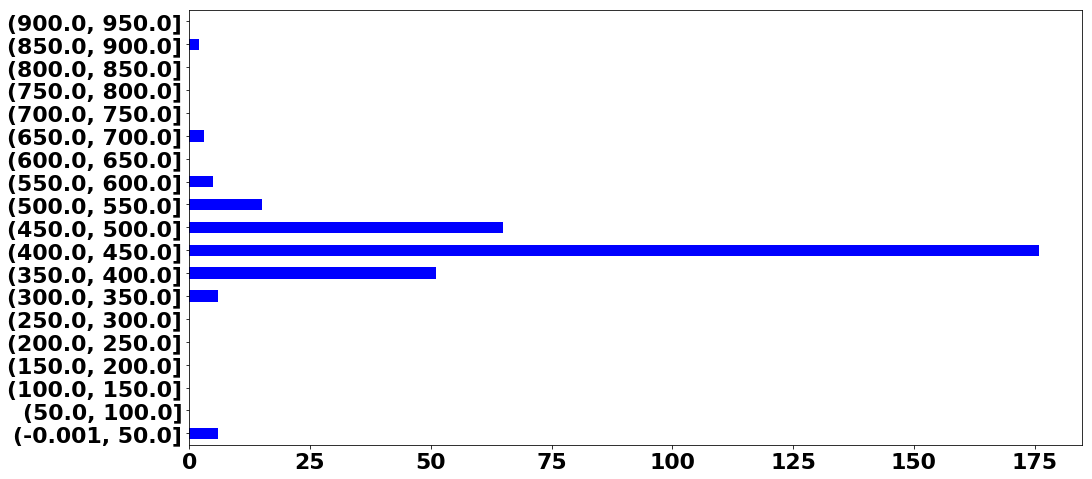

In [36]:
fig = pd.cut(df['cao_points'], bins=range(0, 1000, 50), include_lowest=True).\
    value_counts(sort=False).plot.barh(rot=0, color="blue", figsize=(16, 8))

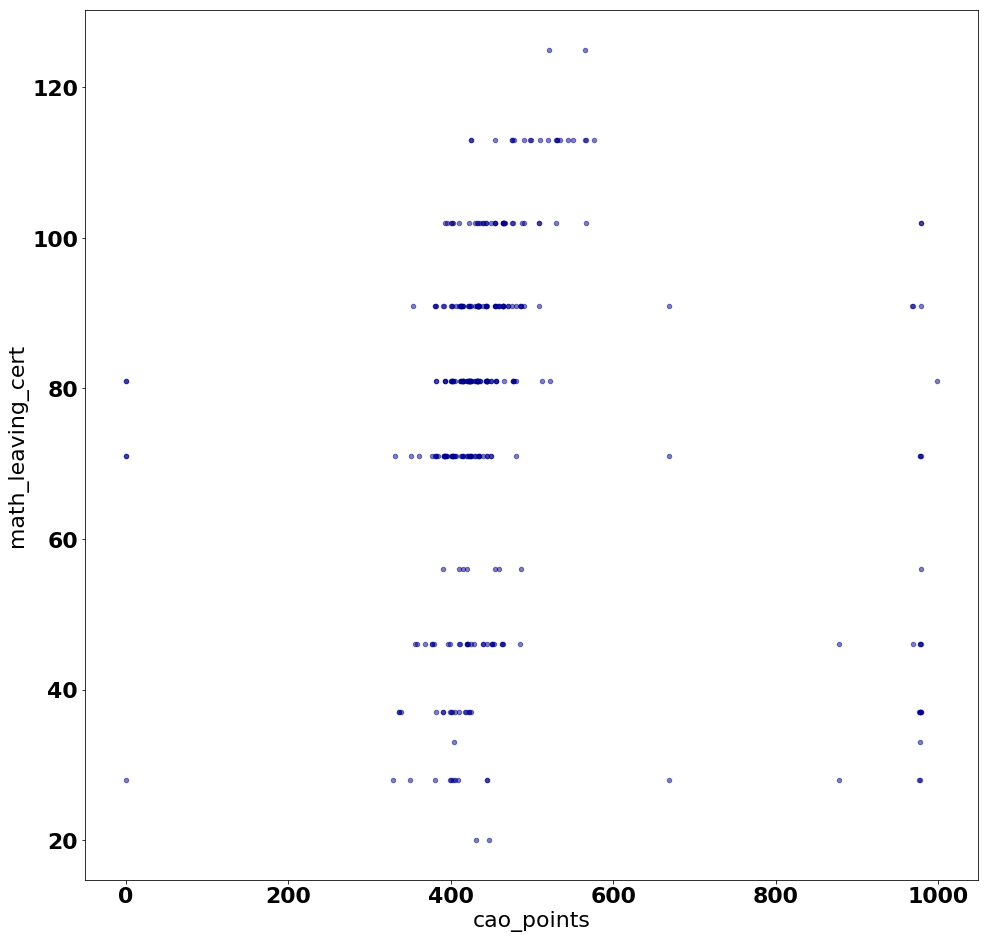

In [37]:
fig = df.plot.scatter(
    x='cao_points',
    y='math_leaving_cert',
    c='DarkBlue', 
    alpha=0.5,
    figsize=(16, 16)
)

In [38]:
fig.get_figure().savefig('../../figures/exploring_CAO_Points_Math_LC.png', bbox_inches="tight")

In [39]:
df[ (df['cao_points'] > 300) & (df['cao_points'] > 650)].corr()

,academic_year_0,academic_year_1,cao_points,math_leaving_cert
academic_year_0,NaN,NaN,NaN,NaN
academic_year_1,NaN,NaN,NaN,NaN
cao_points,NaN,NaN,1.000000,-0.042906
math_leaving_cert,NaN,NaN,-0.042906,1.000000


In [40]:
df.to_csv('../../data/demographics/summary.csv', index=False)

In [41]:
cao_dict = {
    (878, 878): 'Mature',
    (999, 999): 'Deferrals',
    (777, 777): 'FETAC',
    (888, 888): 'McAlleese',
    (978, 979): 'HEAR',
    (968, 969): 'DARE',
    (976, 976): 'Access',
    (778, 778): 'Colaiste Dhulaigh Science',
    (669, 669): 'ELITE Sports',
}

In [42]:
for k, v in cao_dict.items():
    low, high = k
    values = df[(df['cao_points'] >= low) & 
                (df['cao_points'] <= high)]
    print('{} route: {} students'.format(v, len(values)))

Mature route: 2 students
Deferrals route: 1 students
FETAC route: 0 students
McAlleese route: 0 students
HEAR route: 18 students
DARE route: 3 students
Access route: 2 students
Colaiste Dhulaigh Science route: 0 students
ELITE Sports route: 3 students
